# RTE - Forecast energy consumption in French areas


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

import os, warnings


In [2]:
train = pd.read_csv("../input/rte-forecast-energy-evalml/rte_train_preprocessing.csv")
test = pd.read_csv("../input/rte-forecast-energy-evalml/rte_test_preprocessing.csv")
sub = pd.read_csv("../input/rte-forecast-energy-consumption-in-french-areas/sample_submission.csv")

train.shape, test.shape

((717414, 12), (60870, 11))

In [3]:
train.isna().sum().any(), test.isna().sum().any()

(False, False)

In [4]:
X = train.copy()
y = X.pop("energy_consumption")

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, shuffle=True, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((681543, 11), (35871, 11), (681543,), (35871,))

In [6]:
import math
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def evaluates_model(y_test, y_pred):
    print("*"*12, "Evaluations : ", "*"*12, '\n')
    
    print("MAE model :", mean_absolute_error(y_test, y_pred))
    
    print("MSE model :", mean_squared_error(y_test, y_pred))
    
    print("R2_Score model :", r2_score(y_test, y_pred))
    
    #mse_1 = np.square(np.subtract(y_test,y_pred)).mean() 
    
    #print("RMSE model :", math.sqrt(mse_1))

# Setup GPU

In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


2022-06-27 19:29:56.642514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 19:29:56.764297: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 19:29:56.765178: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 19:29:56.767914: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Modeling with Keras : Model 0

### Define Model Architecture

In [8]:
from tensorflow.keras import layers

shape = X_train.shape[1]

def build_model0():
    
    model = keras.Sequential([
        layers.Dense(units=2048, input_shape=[shape]),
        layers.Dense(1024, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(units=1)
    ])

    # Prints a string summary of the network.
    #model.summary()
    
    return model

### Build & Compile Model

In [9]:
def build_model():
    
    model = keras.Sequential([
        layers.Dense(units=512, input_shape=[shape]),
        layers.Dense(units=256, activation='swish'),
        layers.Dense(128, activation='swish'),
        layers.Dense(64, activation='swish'),
        layers.Dense(32, activation='swish'),
        layers.Dense(16, activation='swish'),
        layers.Dense(units=1)
    ])

    # Prints a string summary of the network.
    #model.summary()
    
    return model

model = build_model()

model.compile(optimizer="adam",     
               loss='mean_squared_error',
               metrics=[
                    'MeanSquaredError',
                    'mae',
               ]
)

### Training

In [10]:
early_stopping0 = keras.callbacks.EarlyStopping(
    patience=5,
    #min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=128,
    epochs=100,
    callbacks=[early_stopping0],

)

2022-06-27 19:30:00.830719: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
5325/5325 [==============================] - 18s 3ms/step - loss: 241941.4844 - mean_squared_error: 241941.4844 - mae: 254.8653 - val_loss: 128617.7500 - val_mean_squared_error: 128617.7500 - val_mae: 220.9858
Epoch 2/100
5325/5325 [==============================] - 15s 3ms/step - loss: 67791.0234 - mean_squared_error: 67791.0234 - mae: 132.6104 - val_loss: 54424.6289 - val_mean_squared_error: 54424.6289 - val_mae: 112.9170
Epoch 3/100
5325/5325 [==============================] - 16s 3ms/step - loss: 55867.7852 - mean_squared_error: 55867.7852 - mae: 118.8532 - val_loss: 42838.4922 - val_mean_squared_error: 42838.4922 - val_mae: 109.8025
Epoch 4/100
5325/5325 [==============================] - 15s 3ms/step - loss: 57736.1797 - mean_squared_error: 57736.1797 - mae: 117.4071 - val_loss: 64540.8398 - val_mean_squared_error: 64540.8398 - val_mae: 115.6112
Epoch 5/100
5325/5325 [==============================] - 16s 3ms/step - loss: 35491.1211 - mean_squared_error: 35491.1211 - 

### Validation/Evaluation

In [11]:
pred = model.predict(X_valid)
evaluates_model(y_valid, pred)

************ Evaluations :  ************ 

MAE model : 71.55228726793607
MSE model : 20199.767235936746
R2_Score model : 0.984352918156721


Minimum Validation Loss: 20199.7559


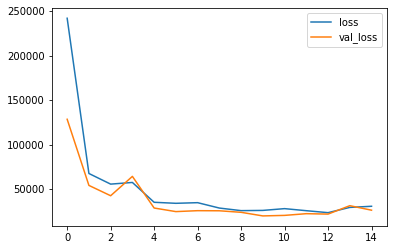

In [12]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

### Submission

In [13]:
sub['energy_consumption'] = model.predict(test)
sub.to_csv('submission_model_relu.csv', index=False)
sub.describe()

,id,energy_consumption
count,60870.00000,60870.000000
mean,30434.50000,931.804688
std,17571.79978,1232.304688
min,0.00000,80.298065
25%,15217.25000,302.026207
50%,30434.50000,469.486816
75%,45651.75000,981.693878
max,60869.00000,6674.708984


### Save Model

In [14]:
model.save('model0.keras')
#model = keras.models.load_model('path/to/location')

# Model 1

In [15]:
def build_model1():
    
    model = keras.Sequential([
        layers.Dense(units=1024, input_shape=[shape]),
        layers.Dense(1024, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1024, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1),
    ])
    
    return model

#model1 = build_model1()

#model1.compile(optimizer="adam", loss="mae", metrics=['mae'],)

In [16]:
"""
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model1.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=20,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))
"""

'\nearly_stopping = keras.callbacks.EarlyStopping(\n    patience=5,\n    min_delta=0.001,\n    restore_best_weights=True,\n)\n\nhistory = model1.fit(\n    X_train, y_train,\n    validation_data=(X_valid, y_valid),\n    batch_size=512,\n    epochs=20,\n    callbacks=[early_stopping],\n)\n\nhistory_df = pd.DataFrame(history.history)\nhistory_df.loc[0:, [\'loss\', \'val_loss\']].plot()\nprint(("Minimum Validation Loss: {:0.4f}").format(history_df[\'val_loss\'].min()))\n'

In [17]:
"""
pred = model1.predict(X_valid)
evaluates_model(y_valid, pred)
"""

'\npred = model1.predict(X_valid)\nevaluates_model(y_valid, pred)\n'

In [18]:
"""
sub['energy_consumption'] = model1.predict(test)
sub.to_csv('submission_model1.csv', index=False)
sub.describe()
"""

"\nsub['energy_consumption'] = model1.predict(test)\nsub.to_csv('submission_model1.csv', index=False)\nsub.describe()\n"

In [19]:
#model1.save('model1.keras')

# Model 2

In [20]:
def build_model2():
    
    model = keras.Sequential([
        layers.Dense(1024, activation='relu', input_shape=[shape]),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(1),
    ])
    
    return model


In [21]:
"""
model2 = build_model2()

model2.compile(
    optimizer='sgd',
    loss='mae',
    metrics=['mae'],
)

EPOCHS = 50
history = model2.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=EPOCHS,
    #verbose=0,
)
"""

"\nmodel2 = build_model2()\n\nmodel2.compile(\n    optimizer='sgd',\n    loss='mae',\n    metrics=['mae'],\n)\n\nEPOCHS = 50\nhistory = model2.fit(\n    X_train, y_train,\n    validation_data=(X_valid, y_valid),\n    batch_size=64,\n    epochs=EPOCHS,\n    #verbose=0,\n)\n"

In [22]:
"""
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))
"""

'\nhistory_df = pd.DataFrame(history.history)\nhistory_df.loc[0:, [\'loss\', \'val_loss\']].plot()\nprint(("Minimum Validation Loss: {:0.4f}").format(history_df[\'val_loss\'].min()))\n'

In [23]:
"""
pred = model2.predict(X_valid)
evaluates_model(y_valid, pred)
"""

'\npred = model2.predict(X_valid)\nevaluates_model(y_valid, pred)\n'

In [24]:
"""
sub['energy_consumption'] = model2.predict(test)
sub.to_csv('submission_model2.csv', index=False)
sub.describe()
"""

"\nsub['energy_consumption'] = model2.predict(test)\nsub.to_csv('submission_model2.csv', index=False)\nsub.describe()\n"

In [25]:
#model2.save('model2.keras')